In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from datetime import datetime

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchmetrics import MeanSquaredError

from dlwpt import ROOT
from dlwpt.basic_autoencoder import AutoEncoder, AutoEncoderDataset
from dlwpt.trainer import Trainer
from dlwpt.utils import set_device, get_mnist_datasets

In [37]:
def plot_loss(results):
    with plt.style.context('ggplot'):
        plt.plot('epoch', 'train_loss', data=results, label='Training Loss')
        plt.plot('epoch', 'valid_loss', data=results, label='Validation Loss')
        plt.title('Loss by Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [86]:
NOW = datetime.now().strftime('%Y%m%d-%H%M')
LOG_DIR = ROOT.joinpath('runs', NOW)
BATCH = 128

device = set_device()

In [177]:
train, test = get_mnist_datasets(do_augment=False)
train_ds, test_ds = AutoEncoderDataset(train), AutoEncoderDataset(test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH)
eval_loader = DataLoader(test, batch_size=10)

In [89]:
mod = AutoEncoder(layers=(128, 64, 16), input_shape=(28, 28))
opt = torch.optim.AdamW(mod.parameters(), lr=0.001)
trainer = Trainer(
    mod, epochs=25, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model.pt'),
    optimizer=opt, score_funcs={'mse': MeanSquaredError()}
)
trainer.fit(train_loader, test_loader)

Batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 467/469 [00:07<00:00, 65.87it/s]
                                                                                                                                                                                                    
Batch:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 464/469 [00:07<00:00, 62.87it/s]
                                                                                                                                                                                                    
Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.45it/s]
               

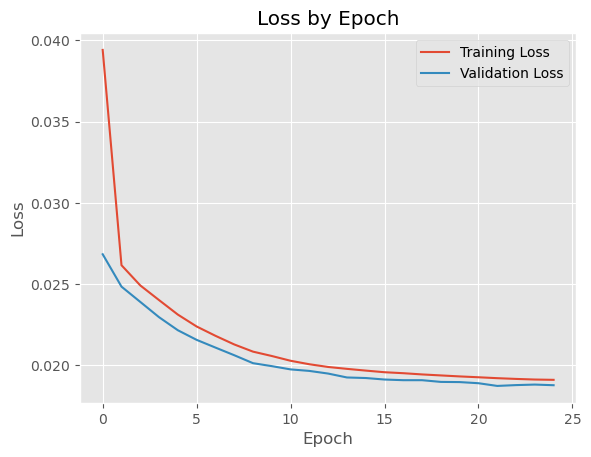

In [90]:
plot_loss(trainer.results)

<hr>

In [160]:
def plot_images(a, b):
    with plt.style.context('grayscale'):
        fig, ax = plt.subplots(1,2, figsize=(4,4))
        ax[0].tick_params(left = False, right = False, labelleft = False,labelbottom = False, bottom = False)
        ax[1].tick_params(left = False, right = False, labelleft = False,labelbottom = False, bottom = False)
        ax[0].imshow(a)
        ax[1].imshow(b)

In [150]:
batch = next(iter(eval_loader))

In [158]:
images = []
mod.eval()
with torch.no_grad():
    for i, x in enumerate(batch[0]):
        images.append((x.squeeze(), mod.predict(x.unsqueeze(0).to(torch.float32).to(device)).squeeze()))

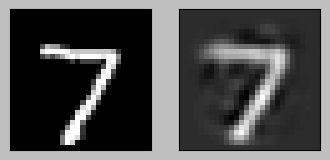

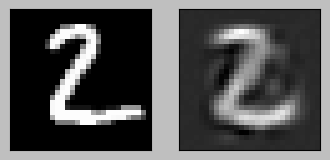

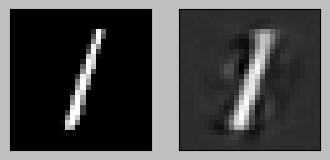

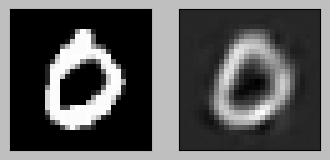

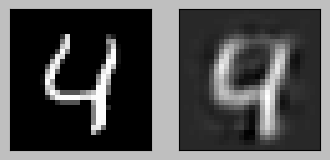

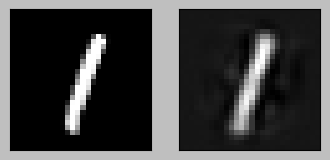

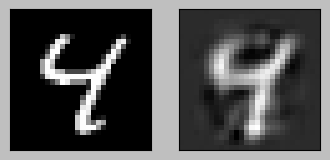

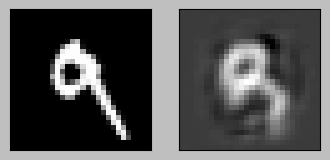

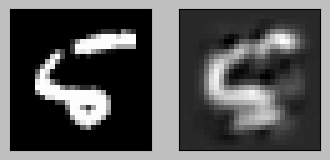

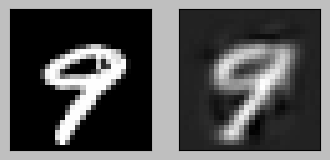

In [164]:
for img in images:
    plot_images(img[0], img[1].cpu())

<hr>

In [223]:
mod = AutoEncoder(layers=(256, 64, 16, 2), input_shape=(28, 28))
opt = torch.optim.AdamW(mod.parameters(), lr=0.001)
trainer = Trainer(
    mod, epochs=25, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model.pt'),
    optimizer=opt, score_funcs={'mse': MeanSquaredError()}
)
trainer.fit(train_loader, test_loader)

Batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 467/469 [00:09<00:00, 53.45it/s]
                                                                                                                                                                                                    
Batch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 467/469 [00:10<00:00, 44.63it/s]
                                                                                                                                                                                                    
Batch:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 465/469 [00:09<00:00, 48.20it/s]
               

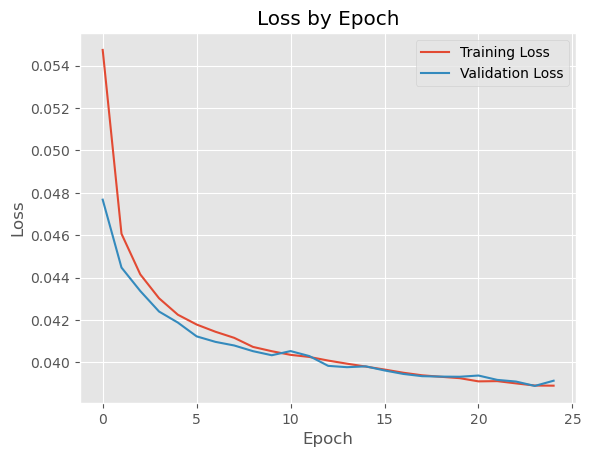

In [224]:
plot_loss(trainer.results)

In [230]:
def get_projections(model, dl):
    z = []
    labels = []

    model.eval()
    with torch.no_grad():
        for x, y in dl:
            z.append(model.encoder(x.to(device)))
            labels.append(y)     
    z = torch.vstack(z).cpu().numpy()
    labels = torch.hstack(labels).cpu().numpy()
    return z, labels

In [232]:
def plot_projections(latent, labels):
    with plt.style.context('ggplot'):
        fig = plt.scatter(latent[:, 0], latent[:, 1], c=labels, cmap='tab10', alpha=0.7)
        plt.legend(*fig.legend_elements())
        plt.title('2D Autoencoder Projections of MNIST Dataset')
        plt.show()

In [225]:
eval_loader = DataLoader(test, batch_size=BATCH)

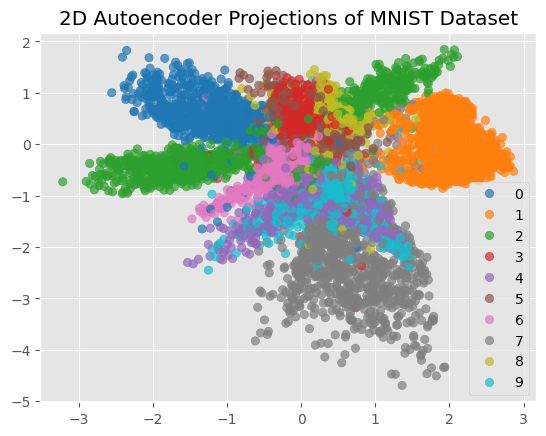

In [234]:
plot_projections(*get_projections(mod, eval_loader))